### Introduction

Potential stories we can tell using the Nobel prize winner dataset:

* Gender disparities among the prize winners
* National trends (e.g., which country has most prizes in Economics)
* Details about individual winners, such as their average age on receiving the prize or life expectancy
* Geographical journey from place of birth to adopted country using the `born_in` and country fields

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import matplotlib
import seaborn as sns

In [4]:
# Newer way of doing matplotlib.style.use('seaborn')
sns.set_theme()

plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['font.size'] = '14'

In [8]:
# Load in dataset
df = pd.read_json(open('../data/nobel_winners_cleaned.json'))

Need to convert date of birth and date of death columns to `datetime64` type in order to make comparisons.

In [9]:
df.date_of_birth = pd.to_datetime(df.date_of_birth)
df.date_of_death = pd.to_datetime(df.date_of_death)

Plotting gender disparity in Nobel prize wins:

<AxesSubplot:xlabel='gender'>

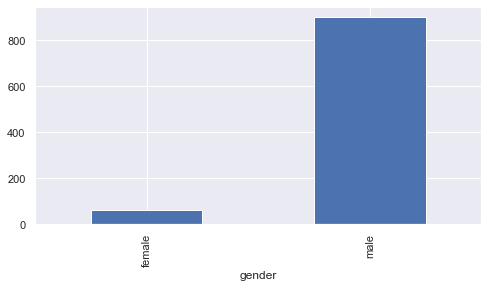

In [10]:
# Group by gender column
by_gender = df.groupby('gender')

# size() method creates Series with integrated plot method
by_gender.size().plot(kind='bar')

The data provided by the `size()` method can also be displayed in chart form with the raw numbers:

In [11]:
by_gender.size()

gender
female     61
male      900
dtype: int64

In addition to the default line plot, the pandas `plot` method takes a `kind` argument to select among other possible plots. Among the more commonly used are:
* `bar` or `barh` (h for horizontal) for bar plots
* `hist` for a histogram
* `box` for a box plot
* `scatter` for scatter plots

### Gender Disparities

Breaking down gender numbers by category of pries. The `groupby` method can take a list of columns to group by, with each group being accessed by multiple keys:

In [12]:
by_cat_gen = df.groupby(['category','gender'])

# Gets group using a category and gender key,
# then selects name and year column from results
by_cat_gen.get_group(('Physics', 'female'))[['name', 'year']]

,name,year
3,Donna Strickland,2018
94,Maria Goeppert-Mayer,1963
378,Andrea Ghez,2020
609,Marie Skłodowska-Curie,1903


Using the `size` method to get the size of the groups returns a Series with a `MultiIndex` that labels the vlaues by both category and gender:

In [13]:
by_cat_gen.size()

category                gender
Chemistry               female      8
                        male      183
Economics               female      2
                        male       90
Literature              female     17
                        male      101
Peace                   female     18
                        male       92
Physics                 female      4
                        male      219
Physiology or Medicine  female     12
                        male      215
dtype: int64

We can plot this multi-indexed Series directly, suing `hbar` as the `kind` argument to produce a horizontal bar chart:

<AxesSubplot:ylabel='category,gender'>

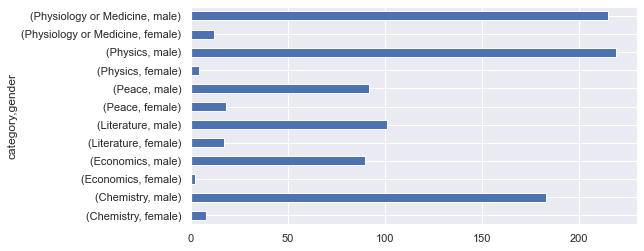

In [14]:
by_cat_gen.size().plot(kind='barh')

### Unstacking Groups

Pandas Series has an `unstack` method that takes the multiple indices and uses them as columns and indices, respectively, to create a new DataFrame. Plotting this DataFrame provides a much more usable plot, as it compares prize wins by gender:

<AxesSubplot:ylabel='category'>

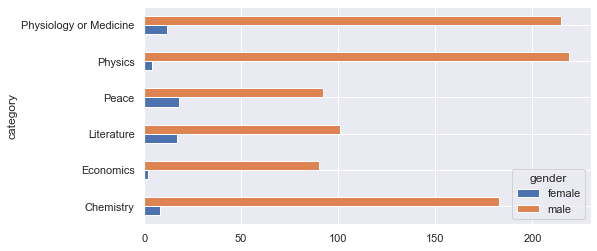

In [15]:
by_cat_gen.size().unstack().plot(kind='barh')

Another useful way to look at this data is to plot the percentage of female winners by category:

In [16]:
# Unstack by_cat_gen group to produce cat_gen_sz df
cat_gen_sz = by_cat_gen.size().unstack()
cat_gen_sz.head()

gender,female,male
category,,
Chemistry,8,183
Economics,2,90
Literature,17,101
Peace,18,92
Physics,4,219


Making a column containing the ratio of female winners to total number of winners:

In [17]:
cat_gen_sz['ratio'] = cat_gen_sz.female / (cat_gen_sz.female + cat_gen_sz.male)
cat_gen_sz.head()

gender,female,male,ratio
category,,,
Chemistry,8,183,0.041885
Economics,2,90,0.021739
Literature,17,101,0.144068
Peace,18,92,0.163636
Physics,4,219,0.017937


Creating a column containing percentage of female winners, multiplying ratio by 100:

In [18]:
cat_gen_sz['female_pc'] = cat_gen_sz['ratio'] * 100

Plotting female percentages on horizontal bar chart, setting x-limit of 100(%) and sorting categories by prize number:

Text(0.5, 0, '% of female winners')

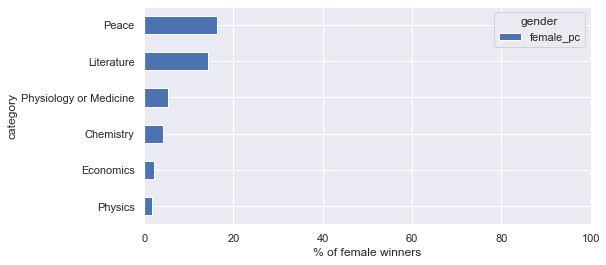

In [19]:
cat_gen_sz = cat_gen_sz.sort_values(by='female_pc', ascending=True)
ax = cat_gen_sz[['female_pc']].plot(kind='barh')
ax.set_xlim([0, 100])
ax.set_xlabel('% of female winners')

### Historical Trends

It would be interesting to see if there has been any increase in female prize allocation in recent years. One way to visualize this would be as grouped bars over time, using `unstack`, but with the year and gender columns.

<AxesSubplot:xlabel='year'>

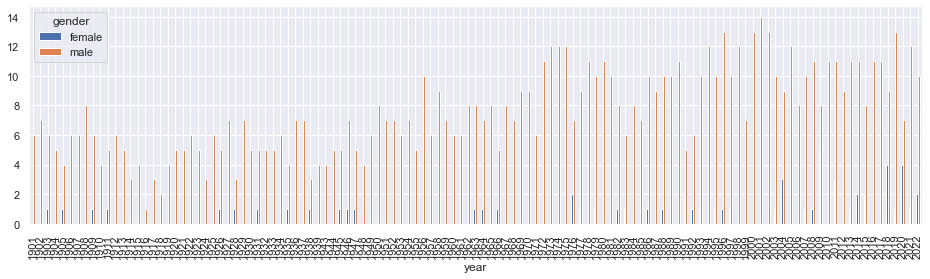

In [20]:
by_year_gender = df.groupby(['year', 'gender'])
year_gen_sz = by_year_gender.size().unstack()
year_gen_sz.plot(kind='bar', figsize=(16, 4))

This plot needs to be cleaned up:
* Reduce number of x-axis labels
* Show gap between 1939-1945, when no prizes were given due to WWII
* Show female and male data on separate plots to reduce number of bars and make comparison easier

In [21]:
def thin_xticks(ax, tick_gap=10, rotation=45):
    """ Thin x-ticks and adjust rotation """
    
    # Gets existing locations and labels of x-ticks (one per bar)
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text()
                  for l in ax.xaxis.get_ticklabels()]
    
    # Sets the new tick locations and labels at an interval
    # of tick_gap (default +10+):
    ax.xaxis.set_ticks(ticks[::tick_gap])
    
    # Rotate lables for readability, default on upward diagonal
    ax.xaxis.set_ticklabels(ticklabels[::tick_gap],
                            rotation=rotation)
    ax.figure.show()

Text(0.5, 0, 'Year')

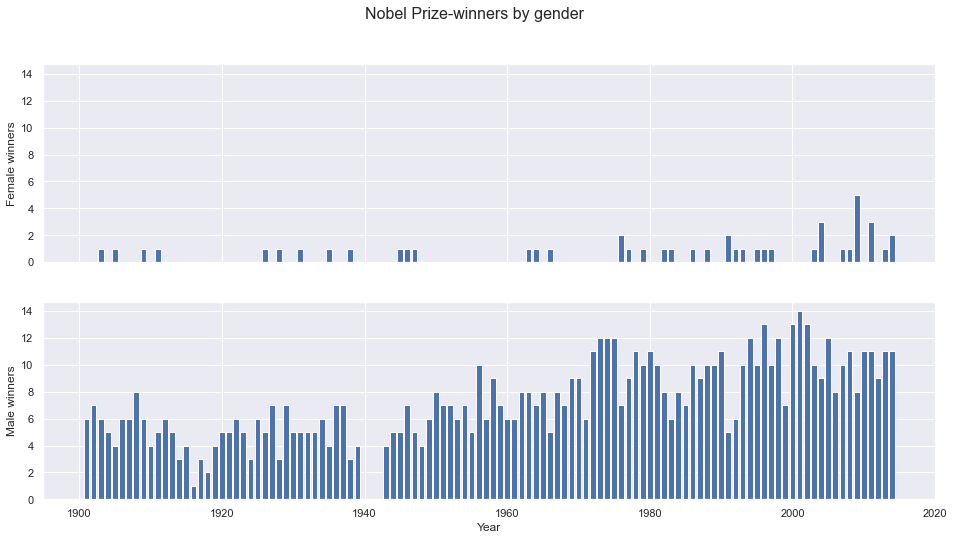

In [22]:
# Manually including all years from start of Nobel Prize to current day
new_index = pd.Index(np.arange(1901, 2015), name='year')
by_year_gender = df.groupby(['year','gender'])

# Replacing discontinuous index with new continuous one
year_gen_sz = by_year_gender.size().unstack().reindex(new_index)

# Stacking bars for visibility
# Creating two axes, on a two (row) by one (col) grid
fig, axes = plt.subplots(nrows=2, ncols=1,
            # Share x and y axes to make comparisons between plots
            sharex=True, sharey=True, figsize=(16, 8))

ax_f = axes[0]
ax_m = axes[1]

fig.suptitle('Nobel Prize-winners by gender', fontsize=16)

# Provide axis' bar chart (bar) method with continuous year index
# and unstacked gender columns
ax_f.bar(year_gen_sz.index, year_gen_sz.female)
ax_f.set_ylabel('Female winners')

ax_m.bar(year_gen_sz.index, year_gen_sz.male)
ax_m.set_ylabel('Male winners')

ax_m.set_xlabel('Year')

### National Trends

To start, plot absolute number of prize winners by country:

<AxesSubplot:xlabel='country'>

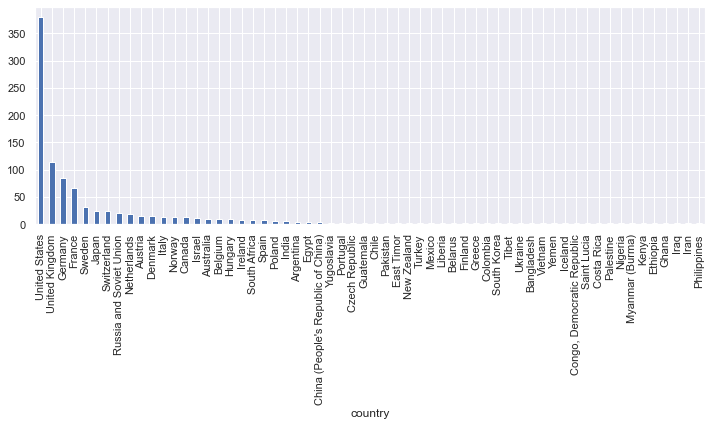

In [23]:
df.groupby('country').size().sort_values(ascending=[False]).plot(kind='bar', figsize=(12,4))

The absolute number of prize winners is bound to favor larger countries, which raises the question, how do the numbers stack up if we account for population sizes? In order to test prize haul per capita, we need to divide the absolute prize numbers by population size. We have country data saved in a separate JSON file which we can use to get the population size.

In [24]:
# Getting national group sizes with country names as index labels
nat_group = df.groupby('country')
ngsz = nat_group.size()

In [26]:
# Loading in country data
df_countries = pd.read_json('../data/world_country_data.json', orient='index')

Our country dataset is already indexed to its name column. If we add to it the `ngsz` national group-size Series, which also has a country name index, the two will combine on the shared indices, giving our country data a new `nobel_wins` column. We can then use this new column to create a `nobel_wins_per_capita` by dividing it by population size:

In [27]:
df_countries = df_countries.set_index('name')
df_countries['nobel_wins'] = ngsz
df_countries['nobel_wins_per_capita'] = df_countries.nobel_wins / df_countries.population

Now, we sort the `df_countries` DataFrame by its new `nobel_wins_per_cap` column and plot data:

<AxesSubplot:xlabel='name'>

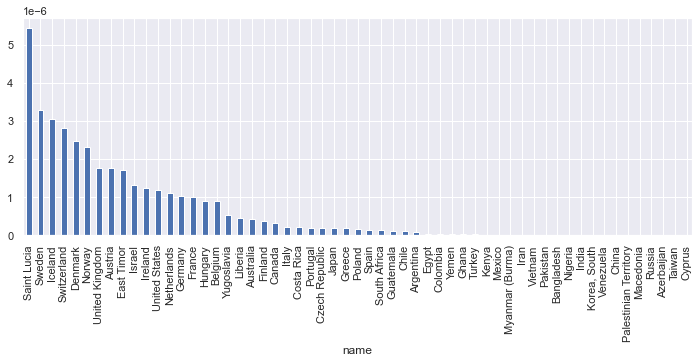

In [28]:
df_countries.sort_values(by='nobel_wins_per_capita',
    ascending=False).nobel_wins_per_capita.plot(kind='bar',
    figsize=(12, 4))

Filtering results for countries that have won more than two Nobel Prizes for different perspective:

<AxesSubplot:xlabel='name'>

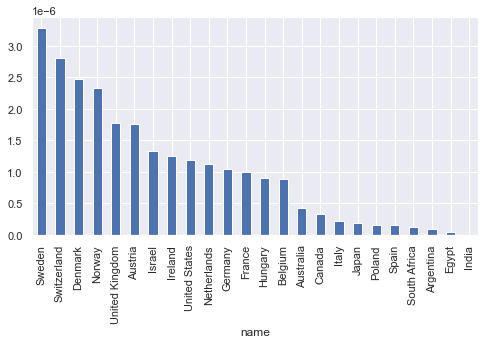

In [29]:
df_countries[df_countries.nobel_wins > 2]\
        .sort_values(by='nobel_wins_per_capita', ascending=False)\
        .nobel_wins_per_capita.plot(kind='bar')

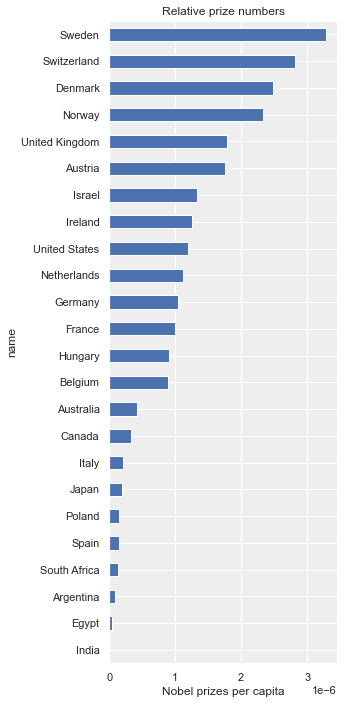

In [35]:
# Creating visualization for web practice
# Threshold for countries with at least three prizes
ax = df_countries[df_countries.nobel_wins > 2]\
    .sort_values(by='nobel_wins_per_capita', ascending=True)\
    .nobel_wins_per_capita.plot(kind='barh',\
        figsize=(5, 10), title="Relative prize numbers")
ax.set_xlabel("Nobel prizes per capita")
ax.set_facecolor("#eee")
plt.tight_layout()
plt.savefig("images/country_relative_prize_numbers.png")

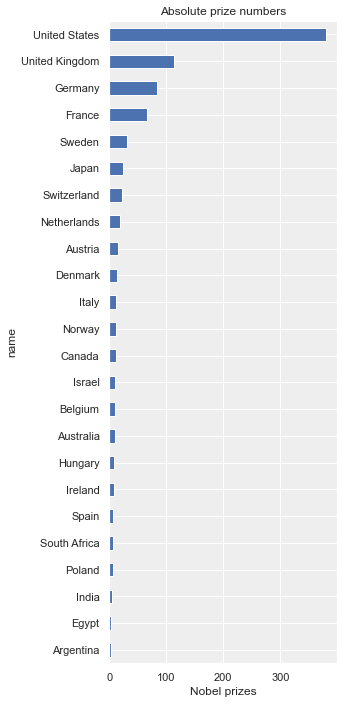

In [36]:
# Doing the same as above for absolute figures
ax = df_countries[df_countries.nobel_wins > 2]\
    .sort_values(by='nobel_wins', ascending=True)\
    .nobel_wins.plot(kind='barh',\
        figsize=(5, 10), title="Absolute prize numbers")
ax.set_xlabel("Nobel prizes")
ax.set_facecolor("#eee")
plt.tight_layout()
plt.savefig("images/country_absolute_prize_numbers.png")

### Prizes by Category

Looking at the wins by category for the absolute prize data will require grouping by country and category columns, getting the size of those groups, unstacking the resulting Series and then plotting the columns of the resulting DataFrame. First, we get our categories with country group sizes:

In [121]:
nat_cat_sz = df.groupby(['country', 'category']).size().unstack()

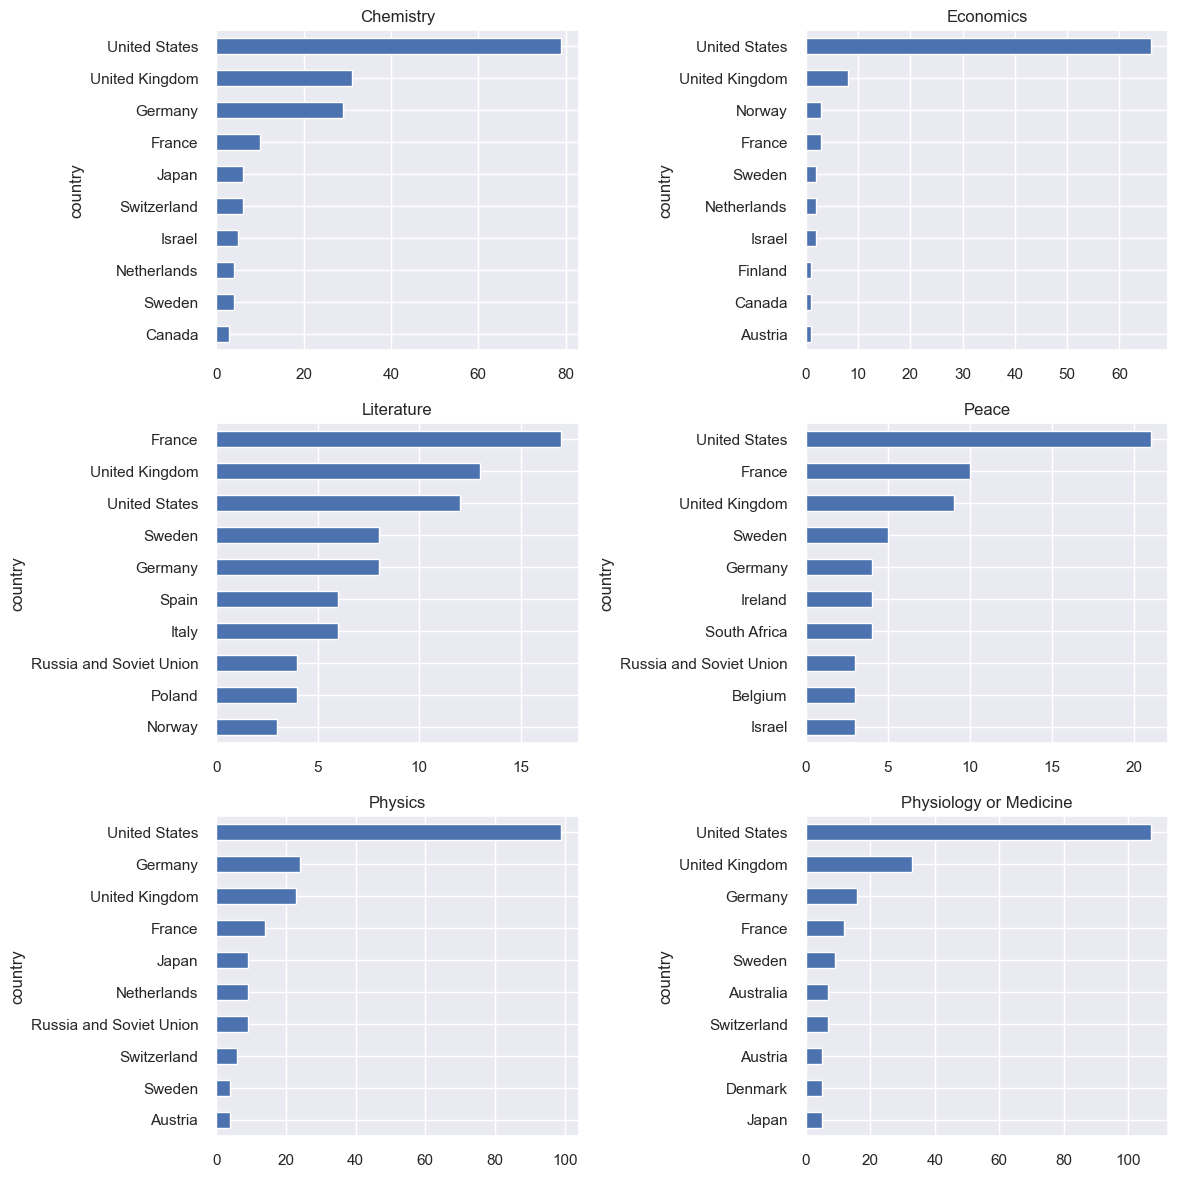

In [125]:
# Use nat_cat_sz df to produce subplots for categories
COL_NUM = 2
ROW_NUM = 3

fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

# items returns an iterator for the DataFrames columns in 
# form of (column_label, column) tuples
for i, (label, col) in enumerate(nat_cat_sz.items()):
    
    # //, integer division operator, returns 
    # rounded-down int value of the division
    ax = axes[i//COL_NUM, i%COL_NUM] 
    
    # Sorts column’s Series by first making a copy 
    # Equivalent of sort(inplace=False)
    # Slice off largest 10 countries
    col = col.sort_values(ascending=[False])[:10]
    
    # Reverse order to show largest countries at top
    col = col.sort_values(ascending=True)
    col.plot(kind='barh', ax=ax)
    ax.set_title(label)

# Prevent label overlaps
plt.tight_layout()

### Historical Trends in Prize Distribution

To explore historical trends to the prize distribution, we can create a new unstacked DataFrame based on the year and country columns. The trend we’re interested in is the cumulative sum of Nobel Prizes by country over its history. 

In [126]:
# Continuous years
new_index = pd.Index(np.arange(1901, 2015), name='year')
by_year_nat_sz = df.groupby(['year', 'country'])\
    .size().unstack().reindex(new_index)

Pandas has a cumsum method that can be plotted into a cumulative line plot:

<AxesSubplot: xlabel='year'>

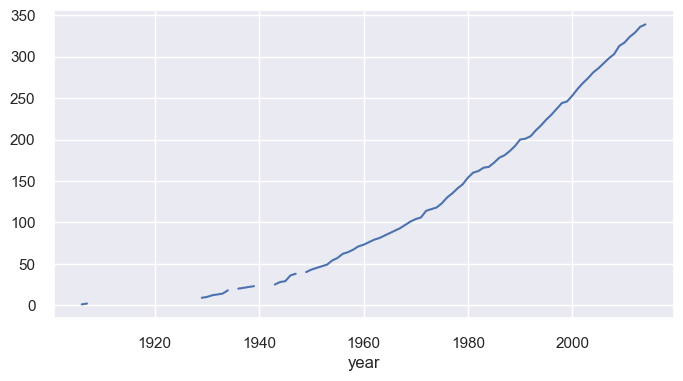

In [128]:
by_year_nat_sz['United States'].cumsum().plot()

The gaps represent the `NaN` values, where the US won no prizes. These can be filled in with zeroes to provide a continuous line:

<AxesSubplot: xlabel='year'>

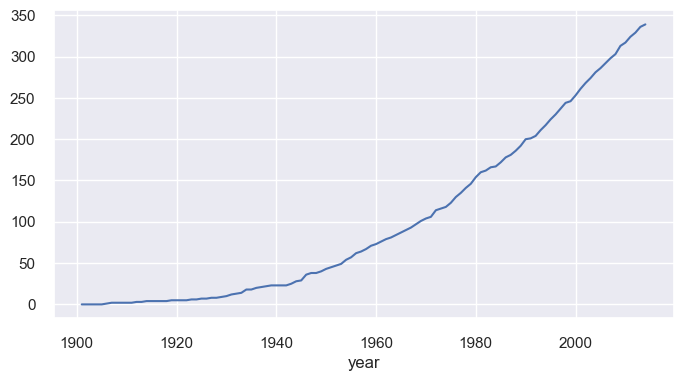

In [129]:
by_year_nat_sz['United States'].fillna(0).cumsum().plot()

Comparing US prize rate with rest of the world:

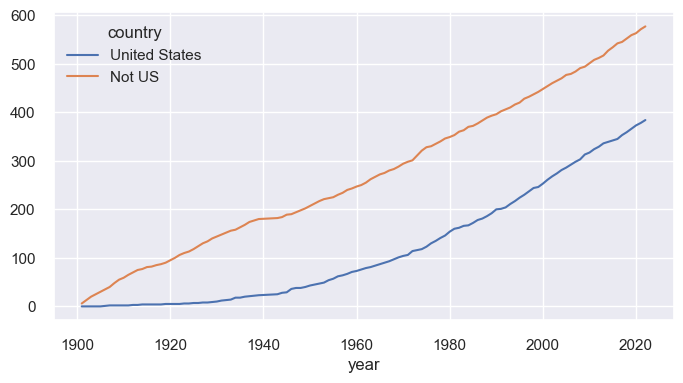

In [131]:
by_year_nat_sz = df.groupby(['year', 'country']).size().unstack().fillna(0)

# Gets list of country column names and removes US
not_US = by_year_nat_sz.columns.tolist()
not_US.remove('United States')

# Uses list of non-US countries to create new 'Not_US' col, 
# showing the sum of all prizes for non-US countries
by_year_nat_sz['Not US'] = by_year_nat_sz[not_US].sum(axis=1)
ax = by_year_nat_sz[['United States', 'Not US']].cumsum().plot()

While rest of the world shows a steady increase, US data increases rapidly after WWII. We can break this down by continent for more insight:

<AxesSubplot: xlabel='year'>

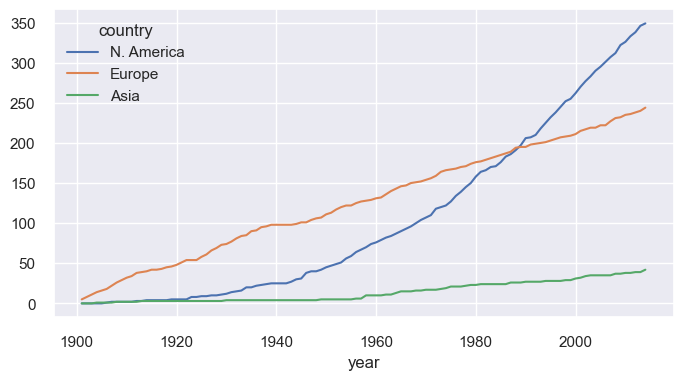

In [133]:
by_year_nat_sz = df.groupby(['year', 'country'])\
    .size().unstack().reindex(new_index).fillna(0)

# Continental country list, selecting biggest two or
# three winners from each continent compared
regions = [
    {'label':'N. America',
      'countries':['United States', 'Canada']},
    {'label':'Europe',
     'countries':['United Kingdom', 'Germany', 'France']},
    {'label':'Asia',
     'countries':['Japan', 'Russia and Soviet Union', 'India']}
]

# Creates new col with region label for each dict in 
# regions list, summing its countries members
for region in regions:
    by_year_nat_sz[region['label']] =\
        by_year_nat_sz[region['countries']].sum(axis=1)

by_year_nat_sz[[r['label'] for r in regions]].cumsum().plot()

Expanding on this, we can summarize the prize rates for the 16 biggest winners, excluding the outlying United States:

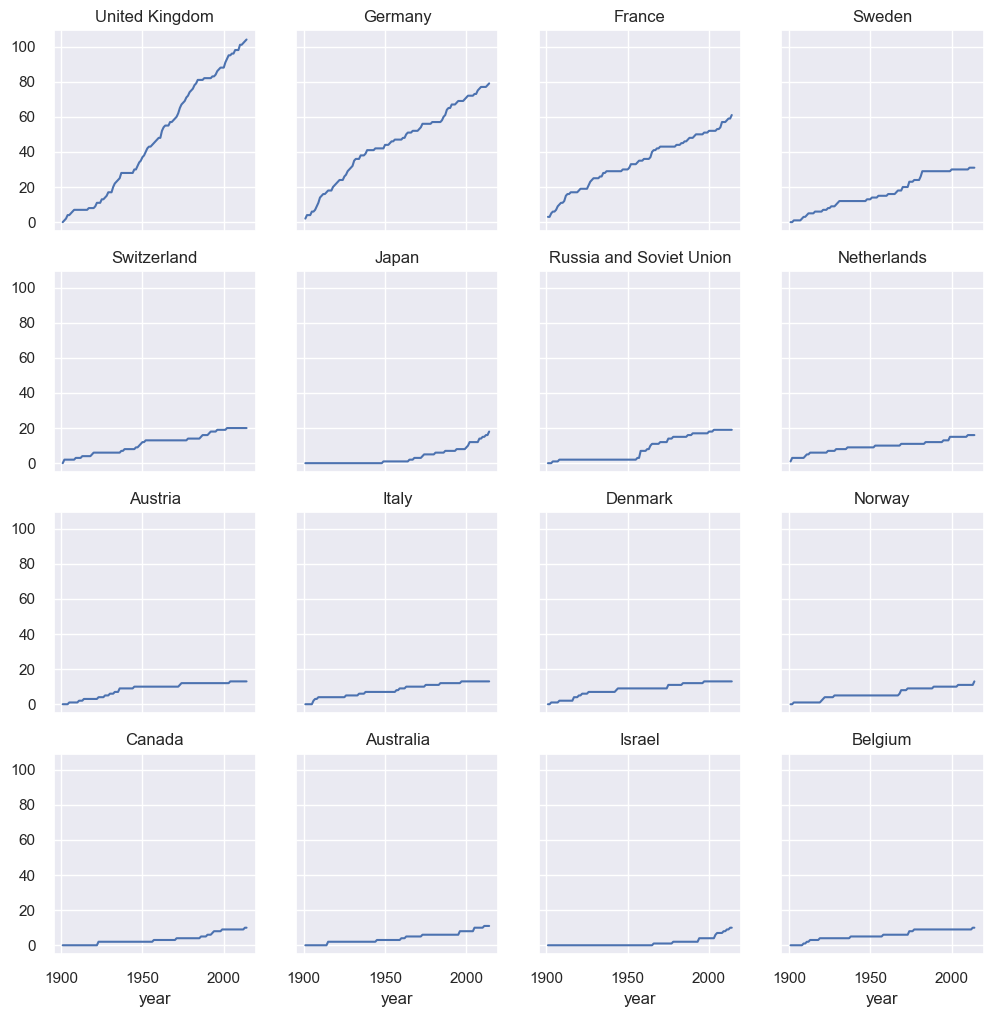

In [144]:
COL_NUM = 4
ROW_NUM = 4

by_nat_sz = df.groupby('country').size()

# Sorts coutnry groups from highest to lowest win-hauls
by_nat_sz.sort_values(ascending=False, inplace=True)

# Gets 4x4 grid of axes with shared x and y axes for normalized comparison
fig, axes = plt.subplots(COL_NUM, ROW_NUM, sharex=True, sharey=True, figsize=(12,12))

# Enumarates over sorted index from second row, excluding US
for i, nat in enumerate(by_nat_sz.index[1:17]):
    ax = axes[i//COL_NUM, i%ROW_NUM]
    
    # Selects nat country name column and plots cumsum of prizes on grid axis ax
    by_year_nat_sz[nat].cumsum().plot(ax=ax)
    ax.set_title(nat)

Another good way to summarize national prize rates over time is by using a heatmap and dividing the totals by decade. The seaborn library provides a good heatmap.

In [145]:
import seaborn as sns

sns.set(font_scale = 1.3)

The division of data into chunks is also known as binning, as it creates bins of data. pandas has a `cut` for this, which takes a column of continuous values—in our case, Nobel Prize years—and returns ranges of a specified size. We can supply the DataFrame’s `groupby` method with the result of `cut` and it will group by the range of indexed values.

<AxesSubplot: xlabel='year', ylabel='country'>

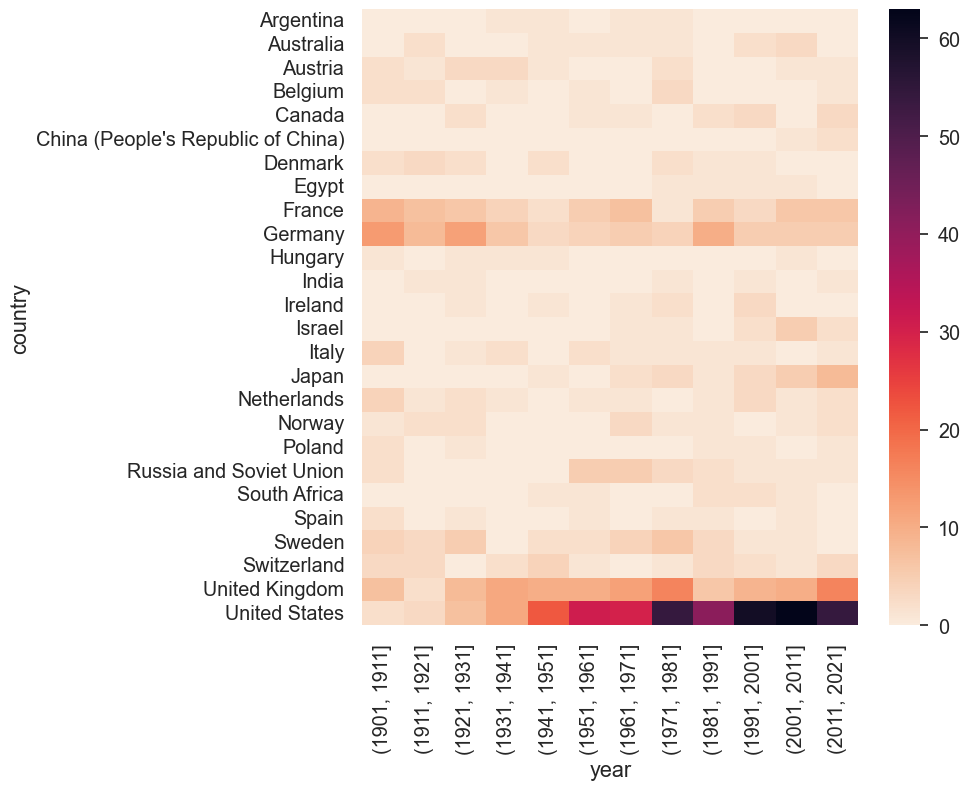

In [153]:
# Gets bin ranges for decades from 1901
bins = np.arange(df.year.min(), df.year.max(), 10)

# Cuts years into decades using bins ranges
# precision=0 gives integer years
by_year_nat_binned = df.groupby(
['country', pd.cut(df.year, bins, precision=0)]).size().unstack().fillna(0)
plt.figure(figsize=(8, 8))

sns.heatmap(\
  # Filters for countries with over 2 prizes
  by_year_nat_binned[by_year_nat_binned.sum(axis=1) > 2],\
  # Secifying rocker_r heatmap style
  cmap='rocket_r')

### Winner Age Distribution

We have the date of birth for all our winners and the date of death for 559 of them. Combined with the year in which they won their prizes, we have a fair amount of individual data to mine. We can investigate the age distribution of winners and try to glean some idea of the winners’ longevity.

<AxesSubplot: >

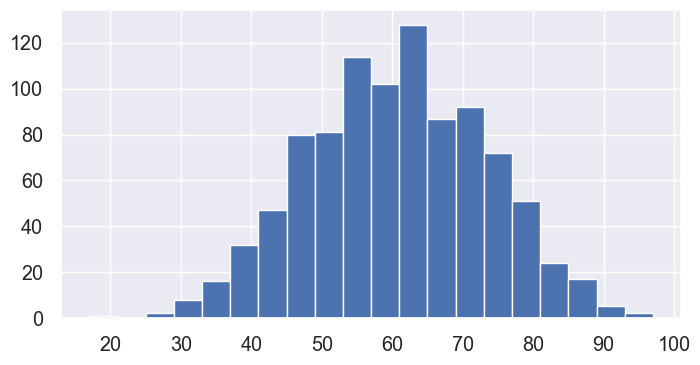

In [154]:
# Quick histogram to assess award age distribution
df['award_age'].hist(bins=20)

We can use seaborn’s `displot` to get a better feel for the distribution, adding a kernel density estimate (KDE) to the histogram:

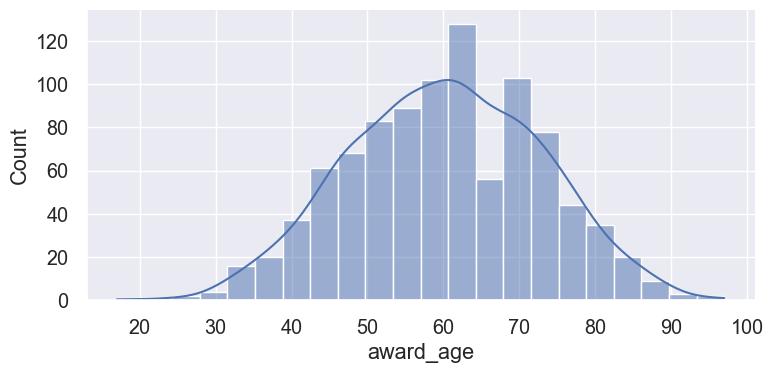

In [155]:
sns.displot(df['award_age'], kde=True, height=4, aspect=2)

A box plot is a good way of visualizing continuous data, showing the quartiles, the first and third marking the edges of the box and the second quartile (or median average) marking the line in the box. Generally, the horizontal end lines (known as the whisker ends) indicate the max and min of the data. We can use a seaborn box plot and divide the prizes by gender:

<AxesSubplot: xlabel='gender', ylabel='award_age'>

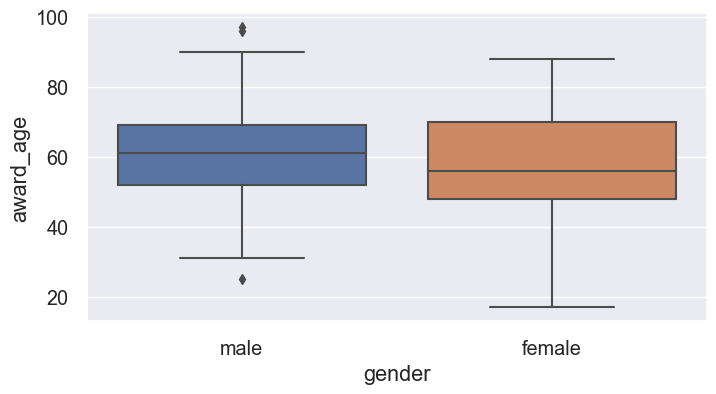

In [156]:
sns.boxplot(df, x='gender', y='award_age')

seaborn’s violin plot combines the conventional box plot with a kernel density estimation to give a more refined view of the breakdown by age and gender:

<AxesSubplot: xlabel='gender', ylabel='award_age'>

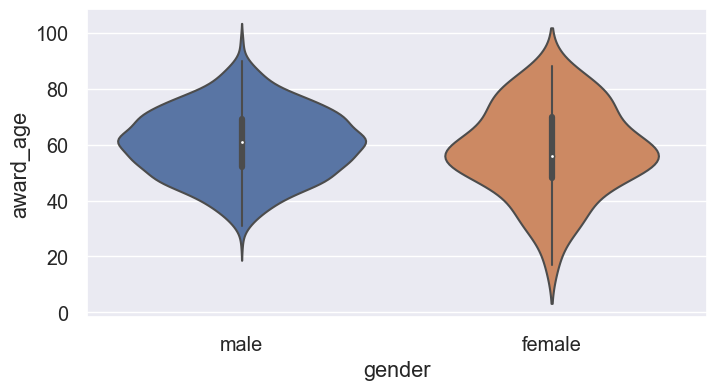

In [157]:
sns.violinplot(data=df, x='gender', y='award_age')

### Life Expectancy of Winners

We can also look at the longevity of Nobel Prize winners, by subtracting the available dates of death from their respective dates of birth. We’ll store this data in a new `'age_at_death'` column:

In [158]:
# The dt method gets the interval in days, dividing it by 365
# to get age of death as a float
df['age_at_death'] = (df.date_of_death - df.date_of_birth).dt.days/365

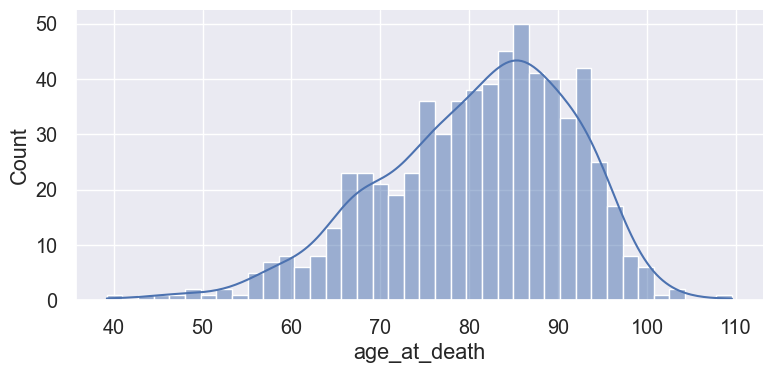

In [159]:
# Making a copy of 'age_at_death' col, removing empty NaN rows
age_at_death = df[df.age_at_death.notnull()].age_at_death

sns.displot(age_at_death, bins=40, kde=True, aspect=2, height=4)

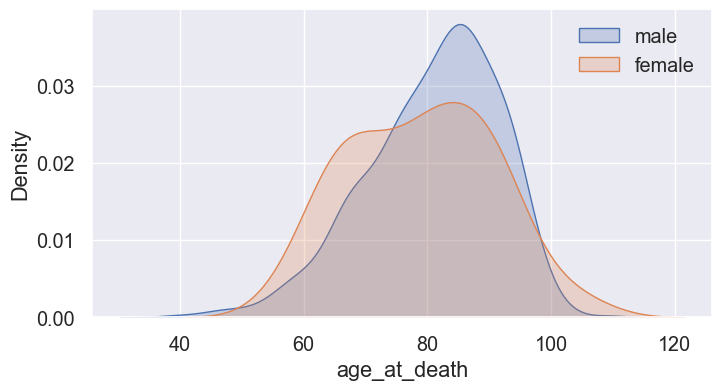

In [165]:
# Superimposing KDEs to show differences in 
# mortality for male and female recipients

# Created df with only valid 'age_at_death' fields
df_temp = df[df.age_at_death.notnull()]

sns.kdeplot(df_temp[df_temp.gender == 'male'].age_at_death, fill=True, label='male')
sns.kdeplot(df_temp[df_temp.gender == 'female'].age_at_death, fill=True, label='female')

plt.legend()

<AxesSubplot: xlabel='gender', ylabel='age_at_death'>

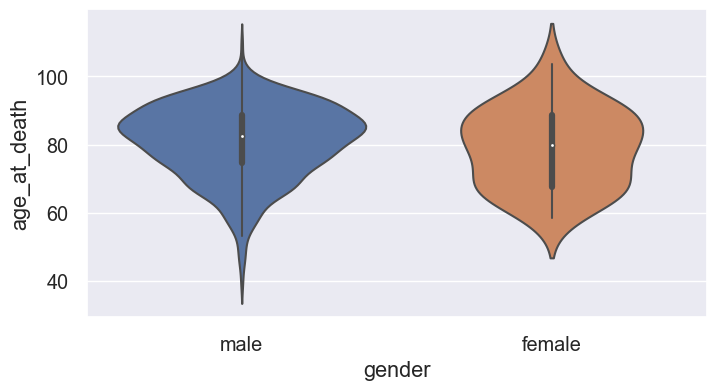

In [166]:
# Violin plot showing same data
sns.violinplot(data=df, x='gender', y='age_at_death',\
               aspect=2, height=4)

### Increasing Life Expectancies over Time

We can also do a historical demographic analysis to see if there’s a correlation between the date of birth of the Nobel Prize winners and their life expectancy. We can use one of seaborn’s `lmplot`s to provide a scatter plot and line-fitting with confidence intervals.

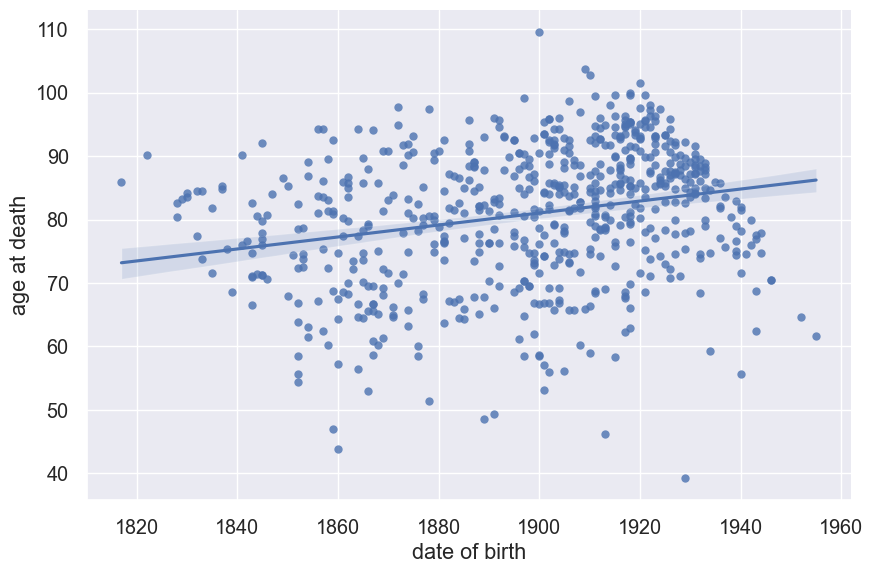

In [170]:
# Temporary df, removing rows with no 'age_at_death'
df_temp = df[df.age_at_death.notnull()]

# New df with only two cols of interest
# Grabbing year of birth using dt accessor
data = pd.DataFrame(
    {'age at death':df_temp.age_at_death,
     'date of birth':df_temp.date_of_birth.dt.year})

sns.lmplot(data=data, x='date of birth', y='age at death',
  height=6, aspect=1.5)

### The Nobel Diaspora

While cleaning the data, we noticed that there were over 100 winners whose country of birth was different from the country in which they won the prize. This might be an interesting story to explore. 

A good way to visualize the movement patterns from the winners’ country of birth to their adopted country is by using a heatmap to show all born_in/country pairs. The following code produces the heatmap:

Text(0.5, 1.0, 'The Nobel Diaspora')

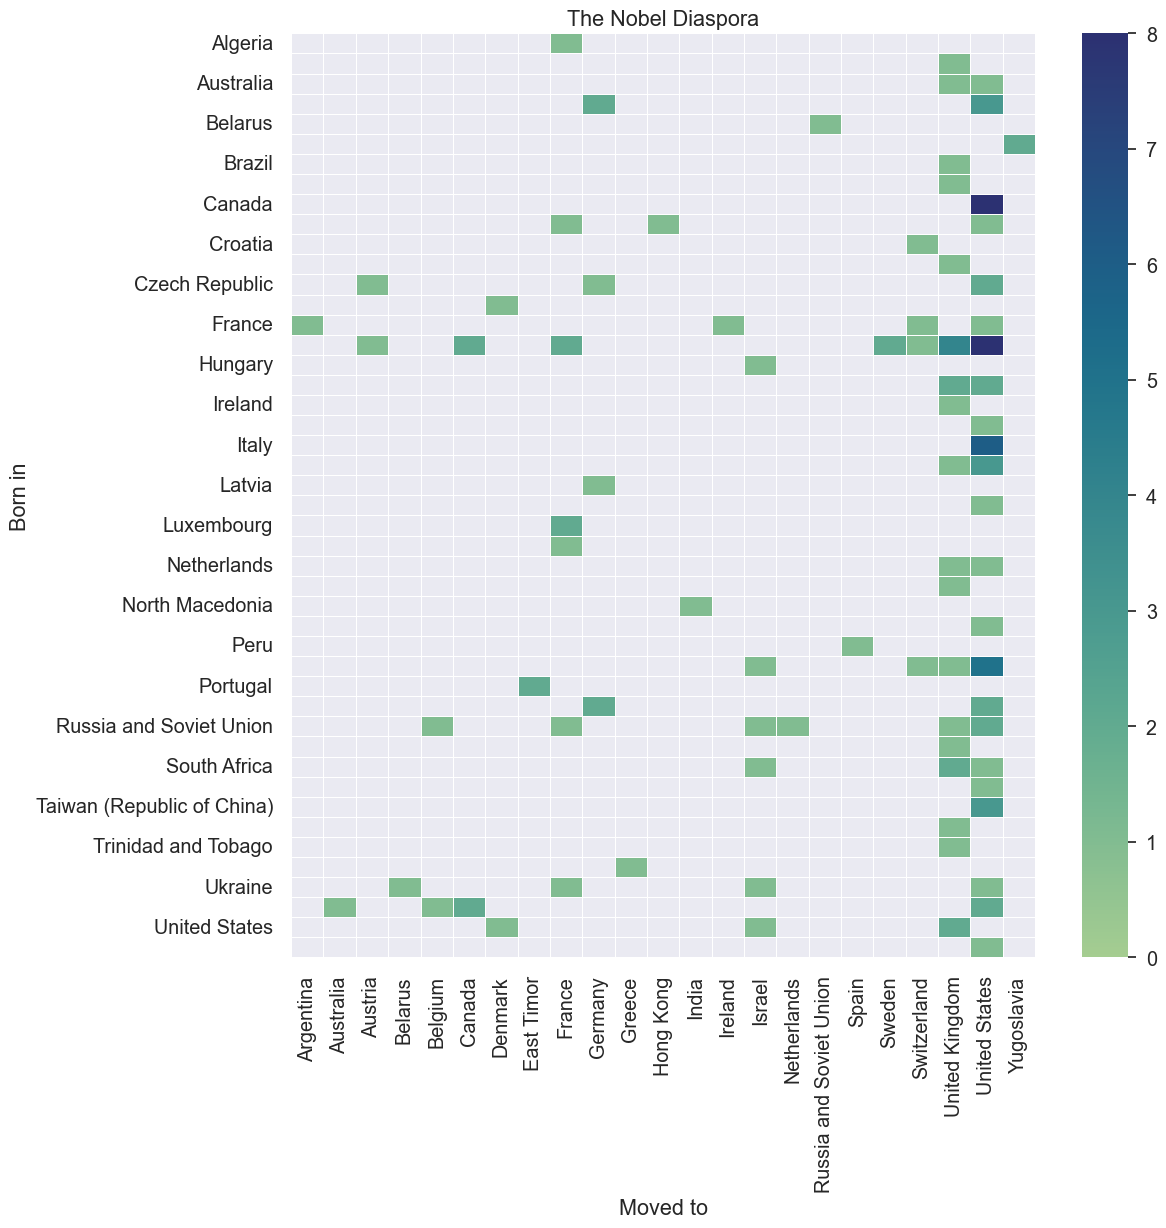

In [173]:
# Selects rows with 'born_in' field and forms group by country
by_bornin_nat = df[df.born_in.notnull()].groupby(\
    ['born_in', 'country']).size().unstack()

# Rename row index and column names to be more descriptive
by_bornin_nat.index.name = 'Born in'
by_bornin_nat.columns.name = 'Moved to'
plt.figure(figsize=(12, 12))

# Seaborn's heatmap attempts to set correct bounds,
# but in this case, we msut manually adjust limits to see all cells
ax = sns.heatmap(by_bornin_nat, vmin=0, vmax=8, cmap="crest", linewidth=0.5)
ax.set_title('The Nobel Diaspora')

Based on this plot, we can see that the United States is the overwhelming recipient of relocated Nobel winners, followed by the United Kingdom. Note that the biggest contingents for both (except cross-border traffic from Canada) are from Germany. Italy, Hungary, and Austria are the next largest groups. Examining the individuals in these groups shows that the majority were displaced as a result of the rise of antisemitic fascist regimes in the run-up to World War II and the increasing persecution of Jewish minorities.